In [1]:
%load_ext autoreload
%autoreload 2

In [186]:
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph
import copy

8 nodes


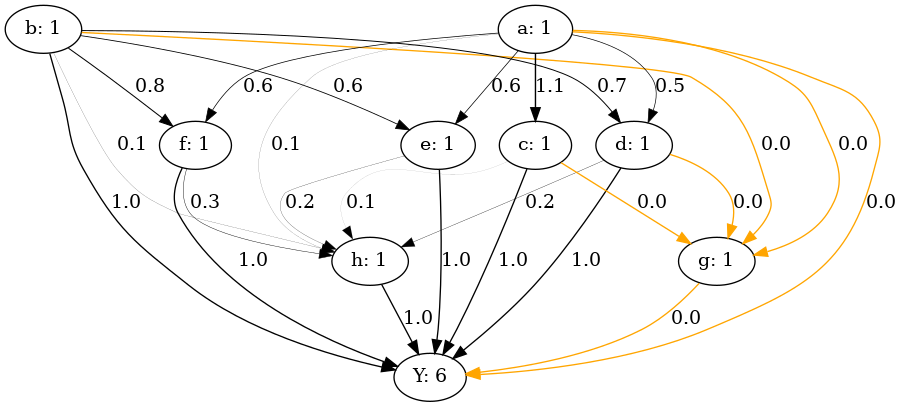

In [184]:
def build_random_graph(n_nodes=8):
    nodes = []
    name = 'a'
    for _ in range(n_nodes):
        args = [nodes[i] for i in range(0 if len(nodes) == 0 else np.random.choice(len(nodes)))]
        node = Node(name, lambda *args: int(sum(args) >= len(args)), args) # and function
        name = chr(ord(name) + 1)
        nodes.append(node)

    print(len(nodes), "nodes")
    source_nodes = get_source_nodes(nodes)
    n_relevant_features = np.random.choice(range(1, len(nodes)))
    feature_mask = np.random.choice(range(1, len(nodes)), n_relevant_features, replace=False)
    args = nodes
    target_node = Node('Y', lambda *args: sum([arg for i, arg in enumerate(args) if i in feature_mask]), 
                       args, is_target_node=True)
    nodes.append(target_node)
    
    graph = Graph(nodes,
                  dict((node.name, lambda: 0) for node in source_nodes),
                  dict((node.name, lambda: 1) for node in source_nodes),
                  )
    return graph

graph = build_random_graph()
verbose = False
cf = CreditFlow(graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

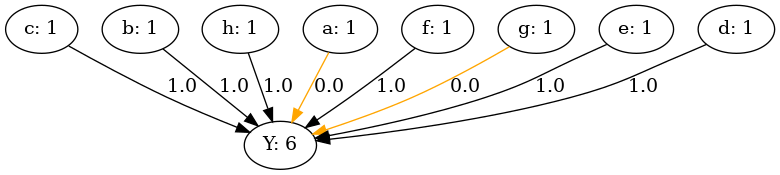

In [187]:
shap_graph = flatten_graph(graph)
verbose = False
cf = CreditFlow(shap_graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

# set arbitrary boundary

In [188]:
def a(*args): return args[0]

a(1,2,3)

1

In [ ]:
def merge_h(node1, node2):
    '''assume node 1 depend on node2, otherwise return node1'''
    if node2 in node1.args:
        idx = node1.args.index(node2)
        def f(*args):
            node2_args, node1_args = args[:len(node2.args)], args[len(node2.args):]
            v = node2.f(*node2_args)
            return node1.f(*(node1_args[:idx] + [v] + node1_args[idx:]))
            
        args = node2.args + node1.args[:idx] + node1.args[idx+1:]
        node1 = Node(node1.name, f, args)

        # rewire its parent to this new node
        node1.args
        
    return node1
    
def merge_nodes(nodes):
    '''
    nodes: assume nodes follow topological order, with the last being the target
    '''
    y = nodes[-1]
    for node in nodes[:-1][::-1]:
        y = merge_h(y, node)
    return y
    
def boundary_graph(graph, boundary_nodes):
    '''
    boundary nodes are names of nodes on the boundary
    we collapse all model nodes into a single node
    '''
    # todo: find the boundary node's ancestor and include it in the graph as well
    nodes_in_d = [] # data side
    nodes_to_merge = []
    graph = copy.deepcopy(graph)
    for node in topo_sort(graph):
        if node.name not in boundary_nodes:
            nodes_to_merge.append(node)
            if node.is_target_node:
                break
        else:
            nodes_in_d.append(node)
    
    node = merge_nodes(nodes)
    return Graph(nodes_in_d + [node], graph.baseline_sampler, graph.target_sampler)
        
boundary_graph = boundary_graph(graph, ['a', 'b'])
verbose = False
cf = CreditFlow(boundary_graph, verbose=verbose, nruns=1, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

# simulation of only setting a particular node